# 2. 머신러닝 프로젝트 처음부터 끝까지

## 캘리포니아 주택 가격(California Housing Prices) 데이터셋 사용

- 지도 학습. 단변량 회귀(구역마다 하나의 값을 예측). 다중 회귀(예측에 사용할 특성이 여러 개)
- 성능 측정 지표: 회귀 문제의 전형적인 성능 지표 = 평균 제곱근 오차(RMSE: root mean square error)
    - 오차가 커질수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠하게 해줌
    - 다른 성능 측정 지표: 이상치로 보이는 구역이 많다면 평균 절대 오차(MAE: mean absolute error) 사용
    - RMSE가 MAE보다 조금 더 이상치에 민감함
    - RMSE와 MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extension = 'png', resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id+'.'+fig_extension)
    print('그림 저장: ', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

#### 데이터 불러오기

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

- 위의 fetch_housing_data()를 호출하면 현재 작업공간에 datasets/housing 디렉터리를 만들고 housing.tgz 파일을 내려받고 같은 디렉터리에 압축을 풀어 housing.csv파일을 만듦

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')    
    return pd.read_csv(csv_path)

#### 데이터 살펴보기

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- ocean_proximity칼럼이 object이므로 아마도 범주형(categorical)
- 어떤 카테고리가 있고 각 카테고리마다 얼마나 많은 구역이 있는지 확인

In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- 숫자형 칼럼을 히스토그램으로 그려보기

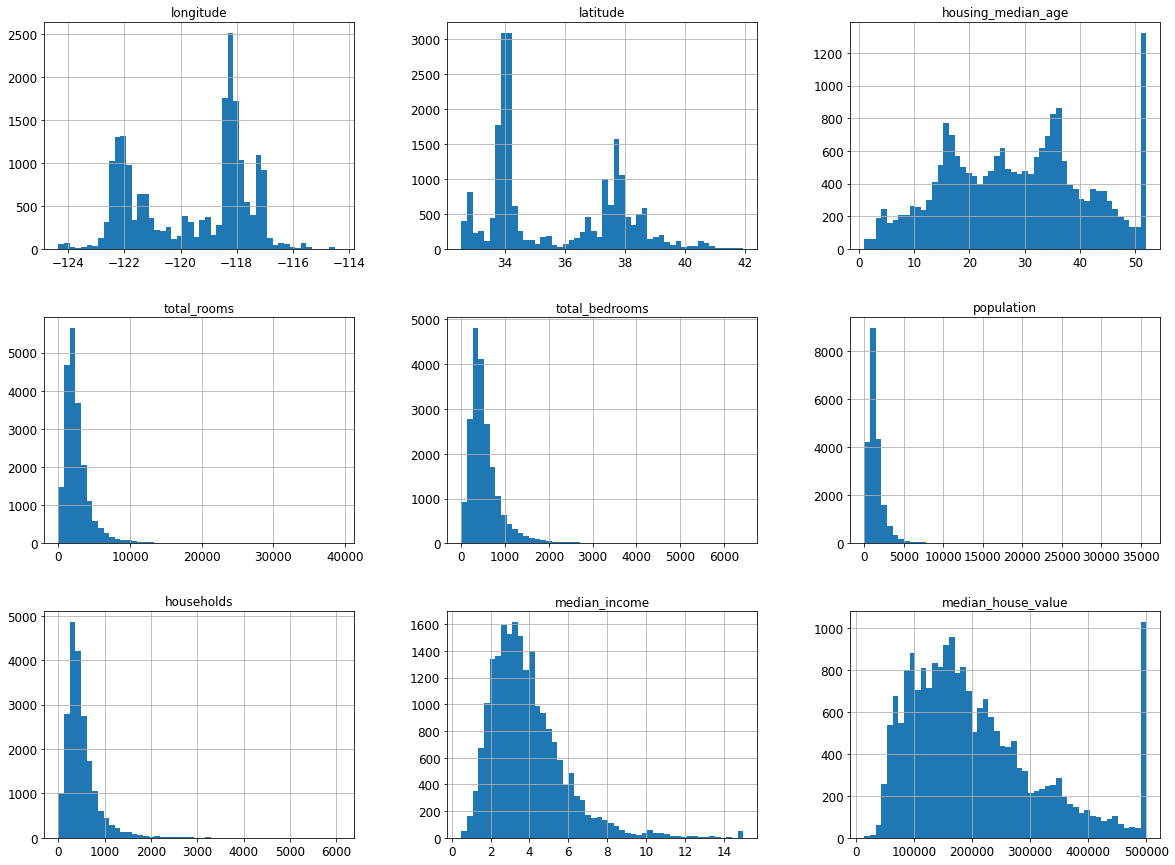

In [9]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

In [10]:
# 테스트 셋 분리 (무작위 샘플링)

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

<AxesSubplot:>

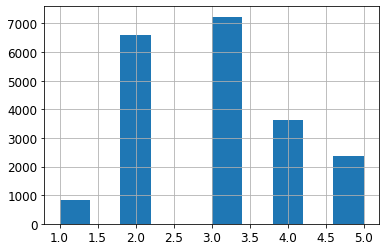

In [11]:
# 계층적 샘플링(stratified sampling)
# 중간 소득이 중간 주택 가격을 예측하는데 매우 중요하다고 가정
## 그렇다면 테스트 셋이 전체 데이터셋에 있는 여러 소득 카테고리를 잘 대표해야함
## 중간 소득이 연속적인 숫자형 특성이므로 소득에 대한 카테고리 특성을 만듦

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])     # 카테고리 1은 0에서 1.5까지범위
housing['income_cat'].hist()

In [12]:
# 소득 카테고리를 기반으로 계층 샘플링

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

- test세트와 전체 세트의 소득 카테고리의 비율이 비슷한지 확인

In [13]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [14]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

- 비슷한 비율로 들어가 있음

In [15]:
# income_cat 특성 다시 삭제

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)

In [16]:
housing = strat_train_set.copy()     # 훈련세트의 복사본 사용

#### 지리적 데이터 시각화

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

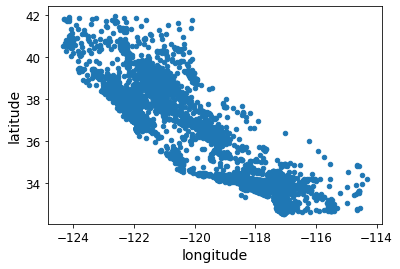

In [17]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

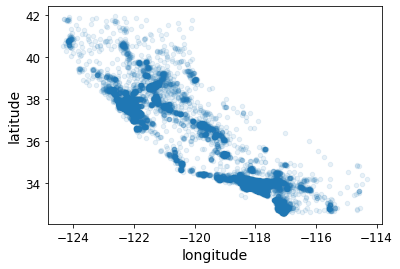

In [18]:
# aplha = 0.1로 하면 데이터 포인트가 밀집된 영역을 잘 보여줌

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

그림 저장:  housing_prices_scatterplot


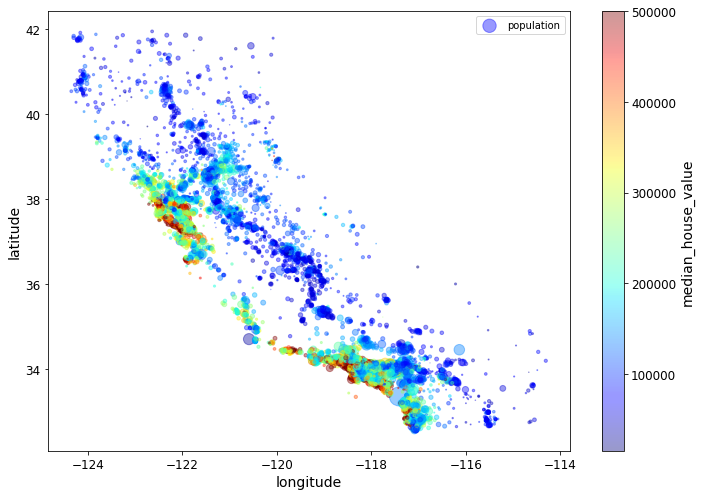

In [19]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population'] / 100, label = 'population',     # 원의 반지름은 구역의 인구를 나타냄
             figsize = (10, 7), c = 'median_house_value',     # 색상은 가격을 나타냄
             cmap = plt.get_cmap('jet'), colorbar = True, sharex = False)     # 빨간색(높은 가격) ~ 파란색(낮은 가격)
plt.legend()
save_fig('housing_prices_scatterplot')

In [20]:
# 캘리포니아 지도 이미지 다운

images_path = os.path.join(PROJECT_ROOT_DIR, 'images', 'end_to_end_project')
os.makedirs(images_path, exist_ok = True)
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
filename = 'california.png'
print('downloading: ', filename)
url = DOWNLOAD_ROOT + 'images/end_to_end_project/' + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

downloading:  california.png


('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x2e077074248>)

그림 저장:  california_housing_prices_plot


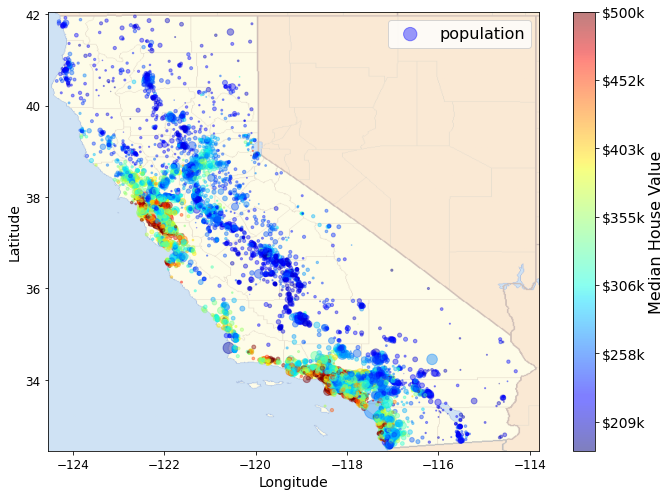

In [21]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filename))

ax = housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', figsize = (10, 7),
                  s = housing['population'] / 100, label = 'population',
                  c = 'median_house_value', cmap = plt.get_cmap('jet'),
                  colorbar = False, alpha = 0.4)
plt.imshow(california_img, extent = [-124.55, -113.80, 32.45, 42.05], alpha = 0.5,
           cmap = plt.get_cmap('jet'))

plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)     # 최소값부터 최대값까지의 수를 균등한 간격으로 11개로 나눔
cbar = plt.colorbar(ticks = tick_values / prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize = 14)
cbar.set_label('Median House Value', fontsize = 16)
plt.legend(fontsize = 16)

save_fig('california_housing_prices_plot')
plt.show()

#### 상관관계 조사

In [22]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [23]:
# 중간 주택 가격과 다른 특성 사이의 상관관계

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

- median_house_value는 median_income이 올라갈 때 증가하는 경향이 있음
- median_house_value는 latitude(위도)와 약한 음의 상관관계. 즉, 북쪽으로 갈수록 주택 가격이 조금씩 내려가는 경향이 있음

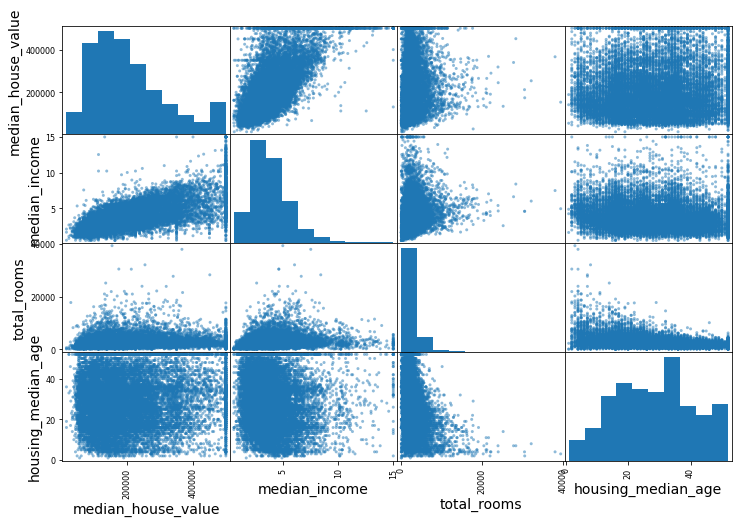

In [24]:
# scatter_matrix를 이용해 중간 주택 가격과 상관관계가 높은 몇 특성 살펴보기

from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12, 8), diagonal = 'hist');     # diagonal에 hist 대신 kde(커널 밀도 추정)도 가능

- median_house_value을 예측하는데 가장 유용할 것 같은 특성은 median_income이므로 상관관계 산점도 확대

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

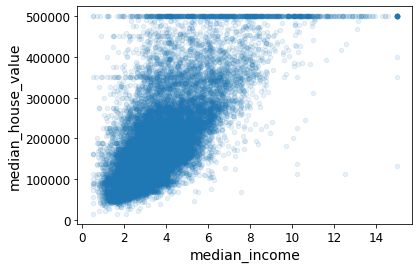

In [25]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)

- 상관관계가 매우 강함
- 위에서도 확인했듯이 가격 제한값이 500,000달러에서 수평선으로 확인됨
- 그 외에도 450,000달러 근처에도 수평선이 보이고, 350,000달러와 280,000달러에도 수평선이 보임
- 알고리즘이 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋음

#### 파생변수 생성

In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

- 새로운 bedrooms_per_room 칼럼은 전체 방 개수나 침실 개수보다 중간 주택 가격과의 상관관계가 훨씬 높음
- 침실/방의 비율이 낮은 집이 더 비싼 경향이 있음
- 가구당 방 개수도 구역 내 전체 방 개수보다 더 유용

#### 머신러닝 알고리즘을 위한 데이터 준비

In [28]:
# 예측 변수와 레이블 분리

housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

#### 데이터 정제

- 결측값이 있는 total_bedrooms 칼럼 정제
    - 해당 구역을 제거하거나
    - 전체 특성을 삭제하거나
    - 특정 값으로 채움(0, 평균, 중간값 등)

In [29]:
sample_incomplete_rows = housing[housing.isnull().any(axis = 1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [30]:
# 옵션1: 결측치 있는 행 삭제

sample_incomplete_rows.dropna(subset = ['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [31]:
# 옵션2: 전체 특성 삭제

sample_incomplete_rows.drop('total_bedrooms', axis = 1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [32]:
# 옵션3: 특정 값으로 채움

median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace = True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


- 중간값으로 결측치 채움
- 이때, 사용한 중간값을 저장해 놓아야 함
    - 나중에 시스템을 평가할 때 테스트 세트에 있는 누락된 값과 시스템이 실제 운영될 때 새로운 데이터에 있는 누락된 값을 채워넣는데 필요하기 때문

In [33]:
# 사이킷런의 SimpleImputer을 사용하면 결측치를 쉽게 대체 가능

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')     # 중간값으로 대체

In [34]:
# 수치형 특성에서만 중간값이 계산되므로 object 특성인 ocean_proximity를 제외한 데이터 복사본 생성

housing_num = housing.drop('ocean_proximity', axis = 1)
housing_num.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736


In [35]:
# 위와 동일한 결과 나오는 코드
# 다른 방법: housing_num = housing.select_dtypes(include = [np.number])

housing.select_dtypes(include = [np.number]).head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736


In [36]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
# imputer는 각 특성의 중간값을 계산해서 그 결과를 객체의 statistics_속성에 저장함

imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [38]:
# 수동으로 중간값 계산

housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [39]:
imputer.strategy

'median'

In [40]:
X = imputer.transform(housing_num)     # 결측치를 학습한 중간값으로 변경. 넘파이 배열

housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736


In [41]:
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

#### 텍스트와 범주형 특성 다루기

In [42]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [43]:
# 범주형 특성을 숫자로 변환

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]     # 10개만 확인

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [44]:
# 카테고리 목록 확인

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 이런 인코딩 방식은 머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 잘못 생각함
- 하지만, 이 경우 '<1H OCEAN', 'INLAND'보다 '<1H OCEAN'과 'NEAR OCEAN'가 더 비슷함
- 이럴땐 카테고리별 이진 특성을 만드는 원핫인코딩 사용

In [45]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)     # 희소 행렬(sparse matrix) 반환
housing_cat_1hot.toarray()     # 밀집 배열로 변환

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [46]:
# 또는 encoder를 만들 때 sparse = False를 지정하면 반환값이 배열로 나옴

cat_encoder = OneHotEncoder(sparse = False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [47]:
cat_encoder.categories_     # 카테고리 리스트 확인

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### 나만의 변환기

In [48]:
# 앞에서 추가해 봤었던 파생변수를 추가하는 변환기

from sklearn.base import BaseEstimator, TransformerMixin

col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):     # *args나 **kargs가 아님
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self     # 더 할일이 없음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)     # 넘파이 배열

In [49]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                     columns = list(housing.columns) + ['rooms_per_household', 'population_per_household'],
                                     index = housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


#### 특성 스케일링(feature scaling)

- min-max 스케일링(정규화. normalization)
- Standard 스케일링(표준화, standardization)


- 스케일링을 할 때는 전체 데이터가 아니고 훈련 데이터에 대해서만 fit()메서드를 적용해야 함
- 그런 다음 훈련 세트와 테스트 세트에 대해 transform()메서드를 사용

#### 변환 파이프라인

In [50]:
# 숫자 특성을 처리하는 간단한 파이프라인

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [51]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [52]:
# 범주형 칼럼과 수치형 칼럼을 한번에 변환

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs)])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

#### 모델 선택과 훈련

#### 훈련 세트에서 훈련하고 평가하기

In [53]:
# 선형 회귀 모델

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [54]:
# 훈련 세트에 있는 몇 개 샘플에 대해 적용

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('예측: ', lin_reg.predict(some_data_prepared))
print('레이블: ', list(some_labels))

예측:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [55]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [56]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)     # squared = False를 하면 RMSE
lin_rmse

68627.87390018745

- 대부분 구역의 중간 주택 가격이 120,000 ~ 265,000 사이인데 예측 오차가 68,628인 것은 좋지 않음
- 이는 모델이 훈련 데이터에 과소적합된 사례

In [57]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [58]:
# decisiontreeregressor 모델

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

- 오차가 0.0으로 나온 것은 모델이 데이터에 과대적합된 것

#### 교차 검증을 사용한 평가

- 사이킷런의 k-fold 교차 검증(k-fold cross-validation) 사용

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

- 사이킷런의 교차 검증 기능은 scoring 매개변수에 (낮을수록 좋은) 비용 함수가 아니라 (클수록 좋은) 효용 함수를 기대함
- 그래서 평균 제곱 오차(MSE)의 반댓값(즉, 음수값)을 계산하는 neg_mean_squared_error함수를 사용
- 마찬가지로 sqrt에서도 -scores로 부호를 바꿈

In [61]:
def display_scores(scores):
    print('점수: ', scores)
    print('평균: ', scores.mean())
    print('표준편차: ', scores.std())
    
display_scores(tree_rmse_scores)

점수:  [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
평균:  71629.89009727491
표준편차:  2914.035468468928


- 선형 회귀 모델보다 결과가 좋지 않음
- 교차 검증으로 모델의 성능을 추정하는 것뿐만 아니라 이 추정이 얼마나 정확한지(표준편차) 측정 할 수 있음

In [62]:
# 선형 회귀 모델의 점수 계산

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균:  69104.07998247063
표준편차:  2880.3282098180657


- 두 결과를 비교해보면 결정 트리 모델이 과대적합되어 선형 회귀 모델보다 성능이 나쁨

In [63]:
# randomforestregressor 모델
## 랜덤포레스트는 특성을 무작위로 선택해서 많은 결정 트리를 만들고 그 예측을 평균 내는 방식으로 작동함
## 이렇게 여러 다른 모델을 모아서 하나의 모델을 만드는 것을 앙상블 학습이라고 함

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [64]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [65]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수:  [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균:  50435.58092066179
표준편차:  2203.3381412764606


- 3가지 모델 중 랜덤포레스트의 결과가 가장 좋으나
- 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮으므로 이 모델도 여전히 훈련 세트에 과대적합되어 있음

In [66]:
# svm 모델

from sklearn.svm import SVR

svm_reg = SVR(kernel = 'linear')
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

#### 모델 세부 튜닝

#### 그리드 탐색

- 탐색하고자 하는 하이퍼파라미터와 시도해볼 값을 지정하면 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용해 평가

In [67]:
# randomforestregressor에 대한 최적의 하이퍼파라미터 조합 탐색

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},     # 3*4 = 12개의 하이퍼파라미터 조합 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}     # 2 * 3 = 6개의 조합 시도
]

forest_reg = RandomForestRegressor()

# 5개의 폴드로 훈련하면 총 (12 + 6) * 5 = 90번의 훈련이 발생함
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
# 최상의 파라미터 조합

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [69]:
# 최적의 추정기에 직접 접근

grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

- 그리드서치에서 테스트한 하이퍼파라미터 조합의 평가 점수 확인

In [70]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63863.051603161686 {'max_features': 2, 'n_estimators': 3}
55529.80845464219 {'max_features': 2, 'n_estimators': 10}
52615.27954254643 {'max_features': 2, 'n_estimators': 30}
59730.23889722352 {'max_features': 4, 'n_estimators': 3}
52856.02887286534 {'max_features': 4, 'n_estimators': 10}
50205.249601349264 {'max_features': 4, 'n_estimators': 30}
59361.19155905192 {'max_features': 6, 'n_estimators': 3}
52034.169562391464 {'max_features': 6, 'n_estimators': 10}
49973.68831425613 {'max_features': 6, 'n_estimators': 30}
58769.579892091526 {'max_features': 8, 'n_estimators': 3}
52191.71788975728 {'max_features': 8, 'n_estimators': 10}
50146.83768051921 {'max_features': 8, 'n_estimators': 30}
61611.145810779504 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53698.66543725098 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60027.99933637639 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52526.98550775542 {'bootstrap': False, 'max_features': 3, 'n_estimators

- max_features = 8, n_estimators = 30일때가 최적

#### 랜덤 탐색

- 그리드 탐색은 비교적 적은 수의 조합을 탐구할 땐 괜찮음
- 하지만 하이퍼파라미터 탐색 공간이 커지면 RandomizedSearchCV를 사용
- 특히, 규제처럼 설정값이 연속형인 경우 랜덤 탐색이 권장됨
- 랜덤 탐색은 그리드 탐색과 거의 같은 방식이지만 가능한 모든 조합을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가함
- 장점
    - 랜덤 탐색을 1000회 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1000개의 값을 탐색함
    - 단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원을 제어할 수 있음

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint(low = 1, high = 200),
                  'max_features': randint(low = 1, high = 8)}
forest_reg = RandomForestRegressor(random_state = 42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions = param_distribs,
                                n_iter = 10, cv = 5, scoring = 'neg_mean_squared_error', random_state = 42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E001821DC8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E001821748>},
                   random_state=42, scoring='neg_mean_squared_error')

In [72]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


- max_features = 7, n_estimators = 180일 때 최적

#### 최상의 모델과 오차 분석

- RandomForestRegressor가 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려줌

In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.62649978e-02, 6.67640400e-02, 4.26077802e-02, 1.99879137e-02,
       1.75175661e-02, 1.80676434e-02, 1.64877379e-02, 3.29535808e-01,
       6.07791361e-02, 1.01647887e-01, 7.36337679e-02, 9.36433276e-03,
       1.57720345e-01, 1.09299962e-04, 3.59839253e-03, 5.91335144e-03])

In [74]:
# (중요도, 특성 이름)

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.32953580818043077, 'median_income'),
 (0.15772034524595407, 'INLAND'),
 (0.10164788681312038, 'pop_per_hhold'),
 (0.07626499776609523, 'longitude'),
 (0.07363376794141403, 'bedrooms_per_room'),
 (0.06676403995895396, 'latitude'),
 (0.06077913611502475, 'rooms_per_hhold'),
 (0.042607780215778136, 'housing_median_age'),
 (0.01998791371264101, 'total_rooms'),
 (0.018067643353368426, 'population'),
 (0.017517566107097145, 'total_bedrooms'),
 (0.016487737893466765, 'households'),
 (0.009364332763709337, '<1H OCEAN'),
 (0.005913351440299671, 'NEAR OCEAN'),
 (0.0035983925305401454, 'NEAR BAY'),
 (0.00010929996210601412, 'ISLAND')]

- 위 결과를 바탕으로 덜 중요한 특성들을 제외할 수 있음
- ocean_porximity의 카테고리 중 하나만 실제로 유용하므로 나머지 카테고리는 제외 가능

#### 테스트 세트로 시스템 평가하기

- 테스트 세트에서 예측 변수와 레이블을 얻은 후 full_pipeline을 사용해 데이터 변환(테스트 세트에서 훈련하면 안 되므로 fit_transform()이 아니라 transform()을 호출해야 함)
- 테스트 세트에서 최종 모델 평가

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47887.610270854515

- 구한 추정값이 얼마나 정확한지 알기 위해 테스트 RMSE에 대한 95% 신뢰 구간(confidence interval)을 계산

In [76]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

array([45933.074424  , 49765.44090898])

- 수동으로 95% 신뢰 구간을 구하면 다음과 같음

In [78]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df = m - 1)
tmargin = tscore * squared_errors.std(ddof = 1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45933.0744240031, 49765.44090898272)

- 또는 t점수 대신 z점수를 사용할 수도 있음

In [79]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof = 1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45933.65983862824, 49764.900569936326)

- 하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통
    - 왜냐하면 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에 새로운 데이터셋에는 잘 작동하지 않을 가능성이 큼

#### 전처리와 예측을 포함한 전체 파이프라인

In [82]:
full_pipeline_with_predictor = Pipeline([
    ('preparation', full_pipeline),
    ('linear', LinearRegression())
])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

#### joblib를 사용한 모델 저장

In [83]:
my_model = full_pipeline_with_predictor

In [84]:
import joblib

joblib.dump(my_model, 'my_model.pkl')

['my_model.pkl']

In [85]:
my_model_loaded = joblib.load('my_model.pkl')

In [86]:
my_model_loaded

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

#### RandomizedSearchCV를 위한 Scipy 분포 함수

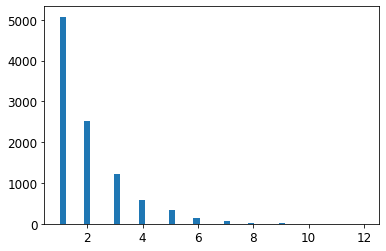

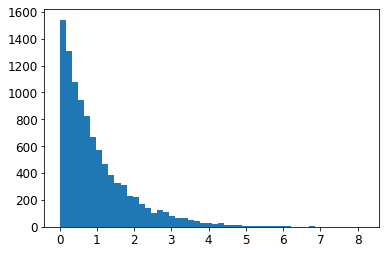

In [89]:
from scipy.stats import geom, expon

geom_distrib = geom(0.5).rvs(10000, random_state = 42)
expon_distrib = expon(scale = 1).rvs(10000, random_state = 42)
plt.hist(geom_distrib, bins = 50)
plt.show()
plt.hist(expon_distrib, bins = 50)
plt.show()

#### 연습문제 - 주택 가격 데이터셋 사용

#### 1. 서포트 벡터 머신 회귀(sklearn.svm.SVR)를 kernel = 'linear'(하이퍼파라미터 C를 바꿔가며)나 kernel = 'rbf'(하이퍼파라미터 C와 gamma를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해봐라. 최상의 SVR모델은 무엇인가?

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear'], 'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]},
    {'kernel': ['rbf'], 'C': [1, 3, 10, 30, 100, 300, 1000],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................................C=10, kernel=linear; total time=   4.9s
[CV] END ................................C=10, kernel=linear; total time=   4.8s
[CV] END ................................C=10, kernel=linear; total time=   5.0s
[CV] END ................................C=10, kernel=linear; total time=   5.0s
[CV] END ................................C=10, kernel=linear; total time=   5.0s
[CV] END ................................C=30, kernel=linear; total time=   5.3s
[CV] END ................................C=30, kernel=linear; total time=   5.0s
[CV] END ................................C=30, kernel=linear; total time=   5.2s
[CV] END ................................C=30, kernel=linear; total time=   5.0s
[CV] END ................................C=30, kernel=linear; total time=   4.7s
[CV] END ...............................C=100, kernel=linear; total time=   5.0s
[CV] END ...............................C=100, 

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.5s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.3s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   9.7s
[CV] END .......................C=10, gamma=0.03, kernel=rbf; total time=   9.5s
[CV] END .......................C=10, gamma=0.03, kernel=rbf; total time=   9.6s
[CV] END .......................C=10, gamma=0.03, kernel=rbf; total time=   9.5s
[CV] END .......................C=10, gamma=0.03, kernel=rbf; total time=   9.5s
[CV] END .......................C=10, gamma=0.03, kernel=rbf; total time=   9.6s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   9.7s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   9.3s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   9.1s
[CV] END ...................

[CV] END .......................C=300, gamma=0.1, kernel=rbf; total time=   8.9s
[CV] END .......................C=300, gamma=0.1, kernel=rbf; total time=   8.4s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   7.8s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   7.8s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   7.7s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   8.2s
[CV] END .......................C=300, gamma=0.3, kernel=rbf; total time=   7.6s
[CV] END .........................C=300, gamma=1, kernel=rbf; total time=   7.8s
[CV] END .........................C=300, gamma=1, kernel=rbf; total time=   8.8s
[CV] END .........................C=300, gamma=1, kernel=rbf; total time=   8.3s
[CV] END .........................C=300, gamma=1, kernel=rbf; total time=   8.5s
[CV] END .........................C=300, gamma=1, kernel=rbf; total time=   8.1s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000],
                          'kernel': ['linear']},
                         {'C': [1, 3, 10, 30, 100, 300, 1000],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

- 최상 모델의 5폴드 교차 검증으로 평가한 점수는 다음과 같다

In [91]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61836196149

In [92]:
# 최상의 하이퍼 파라미터 확인

grid_search.best_params_

{'C': 30000, 'kernel': 'linear'}

- 선형 커널이 RBF커널보다 성능이 나음
- C는 테스트 한 것 중에 최대값이 선택됨
- 따라서 더 큰 값의 C로 그리드서치를 다시 실행해본다면 더 큰 값의 C에서 성능이 높아질 수 있음

#### 2. GridSearchCV를 RandomizedSearchCV로 바꿔보자

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],     # kernel매개변수가 linear일 때는 gamma가 무시됨
    'C': reciprocal(20, 200000),
    'gamma': expon(scale = 1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions = param_distribs,
                                n_iter = 50, cv = 5, scoring = 'neg_mean_squared_error',
                                verbose = 2, random_state = 42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=   9.5s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=   7.8s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=   7.7s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=   7.7s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   4.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   4.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   4.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   4.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   4.2s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.3min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.3min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.3min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=   4.2s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   7.7s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   7.7s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   7.7s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   7.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   7.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.5s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.4s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.2s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.5s
[CV] END C=55.538389

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E00026E508>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E00026ECC8>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

- 최상 모델의 5폴드 교차 검증으로 평가한 점수는 다음과 같음

In [94]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256622

In [95]:
# 최상의 하이퍼파라미터 확인

rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

- RBF 커널이 최적의 하이퍼파라미터 조합
- 보통 랜덤서치가 같은 시간 안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾음

- 여기서 사용된 scale = 1.0인 지수 분포를 살펴보면,
- 일부 샘플은 1.0보다 아주 크거나 작음. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음

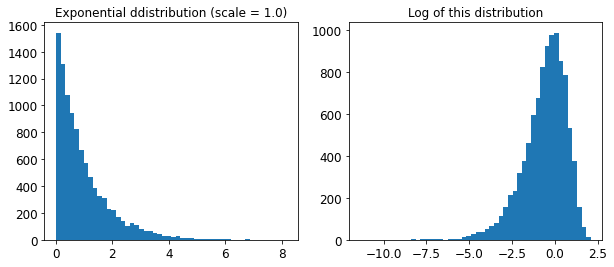

In [96]:
expon_distrib = expon(scale = 1.0)
samples = expon_distrib.rvs(10000, random_state = 42)
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title('Exponential ddistribution (scale = 1.0)')
plt.hist(samples, bins = 50)
plt.subplot(122)
plt.title('Log of this distribution')
plt.hist(np.log(samples), bins = 50)
plt.show()

- C에 사용된 분포는 매우 다름.
- 주어진 범위 안에서 균등 분포로 샘플링 됨
- 그래서 오른쪽 로그 분포가 거의 일정하게 나타남
- 이런 분포는 원하는 스케일이 정확히 무엇인지 모를 때 사용하면 좋음

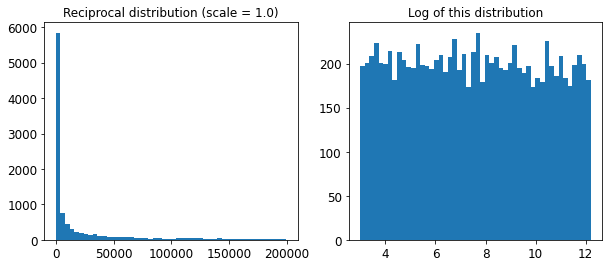

In [97]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state = 42)
plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title('Reciprocal distribution (scale = 1.0)')
plt.hist(samples, bins = 50)
plt.subplot(122)
plt.title('Log of this distribution')
plt.hist(np.log(samples), bins = 50)
plt.show()

- reciprocal()함수는 하이퍼파라미터의 스케일에 대해 전혀 감을 잡을 수 없을 때 사용(오른쪽 그래프에서 볼 수 있듯이 주어진 범위 안에서 모든 값이 균등함)
- 반면, 지수 분포는 하이퍼파라미터의 스케일을 어느정도 알고 있을 때 사용하는 것이 좋음

#### 3. 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보라

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y = None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

- 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정함.
- TopFeatureSelector의 fit() 메서드에서 직접 계산할 수도 있지만 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려짐

In [106]:
# 선택할 특성의 개수 지정

k = 5

In [107]:
# 최상의 k개 특성의 인덱스 확인

top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12], dtype=int64)

In [108]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

- 최상의 k개 특성이 맞는지 다시 확인

In [109]:
sorted(zip(feature_importances, attributes), reverse = True)[:k]

[(0.32953580818043077, 'median_income'),
 (0.15772034524595407, 'INLAND'),
 (0.10164788681312038, 'pop_per_hhold'),
 (0.07626499776609523, 'longitude'),
 (0.07363376794141403, 'bedrooms_per_room')]

- 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듦

In [110]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [111]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

- 처음 3개 샘플의 특성 확인

In [112]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

- 최상의 k개 특성이 맞는지 다시 확인

In [119]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

#### 4. 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어 보라

In [114]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [115]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

- 몇 개의 샘플에 전체 파이프라인 적용

In [116]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print('Predictions: \t', prepare_select_and_predict_pipeline.predict(some_data))
print('Labels: \t\t', list(some_labels))

Predictions: 	 [ 82915.77062052 288057.72329295  95680.82648363 149790.34263837]
Labels: 		 [72100.0, 279600.0, 82700.0, 112500.0]


- 예측 성능이 아주 좋지는 않지만 SVR보다 RandomForestRegressor가 더 나은 것 같음

#### 5. GridSearchCV를 사용해 준비 단계의 옵션을 자동으로 탐색해보라

- 아래 코드에서 훈련 도중 경고를 피하기 위해 OneHotEncoder의 handle_unknown 하이퍼파라미터를 'ignore'로 지정함
- OneHotEncoder는 기본적으로 handle_unknown = 'error'를 사용하기 때문에 데이터를 변환할 때 훈련할 때 없던 범주가 있으면 에러를 냄.
- 기본값을 사용하면 훈련 세트에 모든 카테고리가 들어 있지 않은 폴드를 평가할 때 GridSearchCV가 에러를 일으킴
- 'ISLAND' 범주에는 샘플이 하나이기 때문에 일어날 가능성이 높음
- 일부 폴드에서는 테스트 세트 안에 포함될 수 있음
- 따라서 이런 폴드는 GridSearchCV에서 무시하여 피하는 것이 좋음

In [117]:
full_pipeline.named_transformers_['cat'].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv = 5,
                               scoring = 'neg_mean_squared_error', verbose = 2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   4.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   6.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   6.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   7.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   7.0s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   4.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   6.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   6.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   7.1s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   7.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   7.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   6.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   6.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   6.9s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   4.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   7.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   7.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   7.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   7.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   4.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   7.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   7.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   7.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   7.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   4.5s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   7.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   7.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   7.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   7.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   4.5s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   7.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   7.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   7.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   7.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   4.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   7.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   7.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   7.3s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   7.3s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   4.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   7.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   7.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   7.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   7.2s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   5.0s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   8.1s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   7.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   7.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   7.6s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   5.1s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   7.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   7.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   7.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   7.5s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   5.4s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   8.0s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   7.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   7.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   7.9s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   5.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   8.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   8.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   8.2s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   8.2s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   5.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   8.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   8.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   7.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   8.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   5.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   8.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   7.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   8.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   7.9s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=   5.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=   8.7s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=   8.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=   8.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=   8.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   5.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   8.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   8.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   8.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   8.3s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   5.4s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   8.8s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   8.8s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   8.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=   8.0s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=   5.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=   9.4s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=   9.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=   8.5s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=   9.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=   6.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=   8.9s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=   8.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=   8.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=   9.2s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   5.9s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   8.7s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   8.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   8.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=   8.7s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=   9.0s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=   9.7s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=   9.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  10.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  10.7s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=   7.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=   9.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  10.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  10.3s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  10.4s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=   7.0s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=   9.9s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=   9.7s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  10.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  10.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  10.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  13.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  11.1s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  12.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  14.2s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=   9.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  13.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  12.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  13.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  12.8s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=   9.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  13.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  13.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  11.3s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  10.9s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  14.9s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  13.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  14.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  14.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  13.9s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  15.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  13.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  16.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  15.4s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  13.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  15.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  14.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  16.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  17.0s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  11.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  19.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  16.8s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  18.1s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  16.5s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  12.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  15.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  14.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  18.1s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  15.2s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  14.7s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  16.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  16.8s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  18.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  19.5s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  13.6s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  19.9s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  19.1s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  18.1s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  17.0s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  16.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  19.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  16.2s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  14.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  19.1s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  17.9s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  17.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  19.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  16.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  21.3s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  18.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  18.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  19.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  21.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  16.8s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  16.7s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  21.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  17.7s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  21.2s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  20.9s


C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-pac

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  16.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  15.7s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  18.5s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  17.5s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  18.5s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  19.6s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  19.6s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  19.7s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  21.5s
[CV] 

C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\psuny\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 355, in _fit
    **fit_par

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [118]:
grid_search_prep.best_params_

{'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean'}

- 최상의 Imputer 정책은 most_frequent이고 거의 모든 특성이 유용함(16개 중 15개)
- 마지막 특성(ISLAND)은 잡음이 추가될 뿐.